# Double pendulum motion analysis

*Nathan Keim, April 2019*

This notebook shows how to 
* Find features in a single frame of the double pendulum with colored markers.
* Visualize the chaotic motion of the double pendulum.

In [1]:
import numpy as np
import pims, skimage
import skimage.morphology
from matplotlib import pyplot as pl
import pandas as pd

# Develop image analysis

In [3]:
frames = pims.open('dbl_pend_images/*.png')
len(frames)

5

Frame([[[188, 168, 155],
        [188, 168, 155],
        [188, 168, 155],
        ...,
        [253, 233, 226],
        [252, 232, 225],
        [252, 232, 225]],

       [[187, 167, 154],
        [187, 167, 154],
        [187, 167, 154],
        ...,
        [253, 233, 226],
        [252, 232, 225],
        [252, 232, 225]],

       [[187, 167, 154],
        [187, 167, 154],
        [187, 167, 154],
        ...,
        [252, 232, 225],
        [252, 232, 225],
        [252, 232, 225]],

       ...,

       [[140, 107, 103],
        [140, 107, 103],
        [140, 107, 103],
        ...,
        [192, 164, 162],
        [187, 162, 159],
        [187, 162, 159]],

       [[141, 108, 104],
        [141, 108, 104],
        [141, 108, 104],
        ...,
        [192, 167, 164],
        [188, 165, 164],
        [188, 165, 164]],

       [[141, 108, 104],
        [141, 108, 104],
        [141, 108, 104],
        ...,
        [192, 167, 164],
        [188, 165, 164],
        [188, 165, 164]]], dtype=uint8)
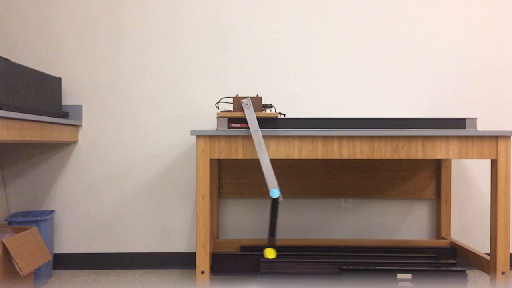

In [8]:
im = frames[4]
im

## Examine HSV representation

* Since markers are bright colors, look at color ("hue") of each pixel.
* Use "HSV" (hue, saturation, luminance) representation of color.

*The mapping from the RGB of the camera to HSV is not always well-defined, so we may get some warnings.*

In [15]:
hsv = skimage.color.rgb2hsv(im)
hue, saturation, luminance = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

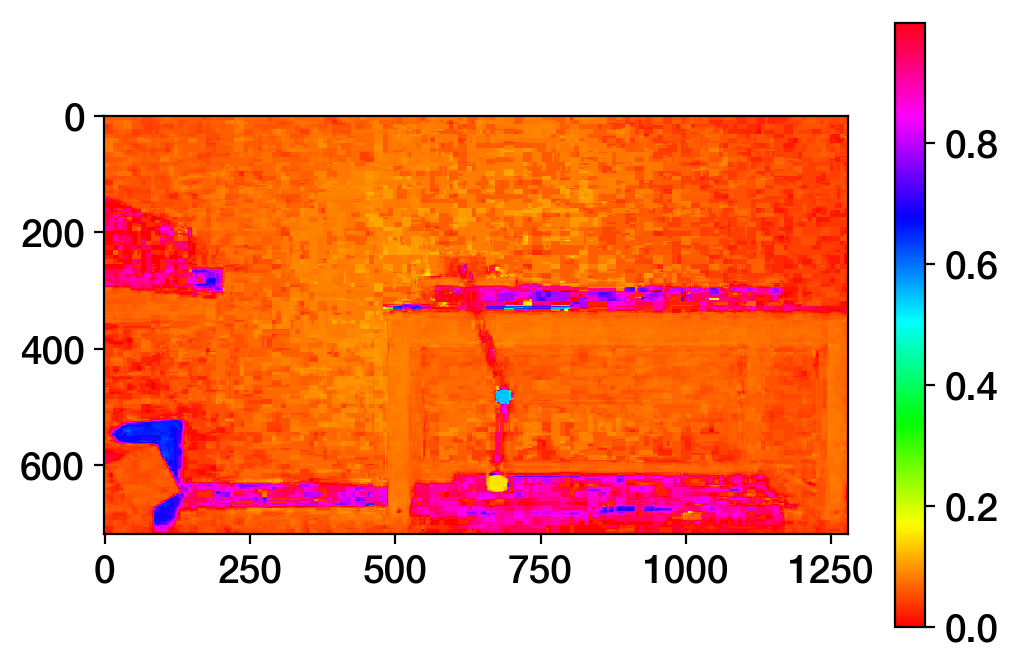

In [11]:
pl.imshow(hue, cmap=pl.cm.hsv)
pl.colorbar()

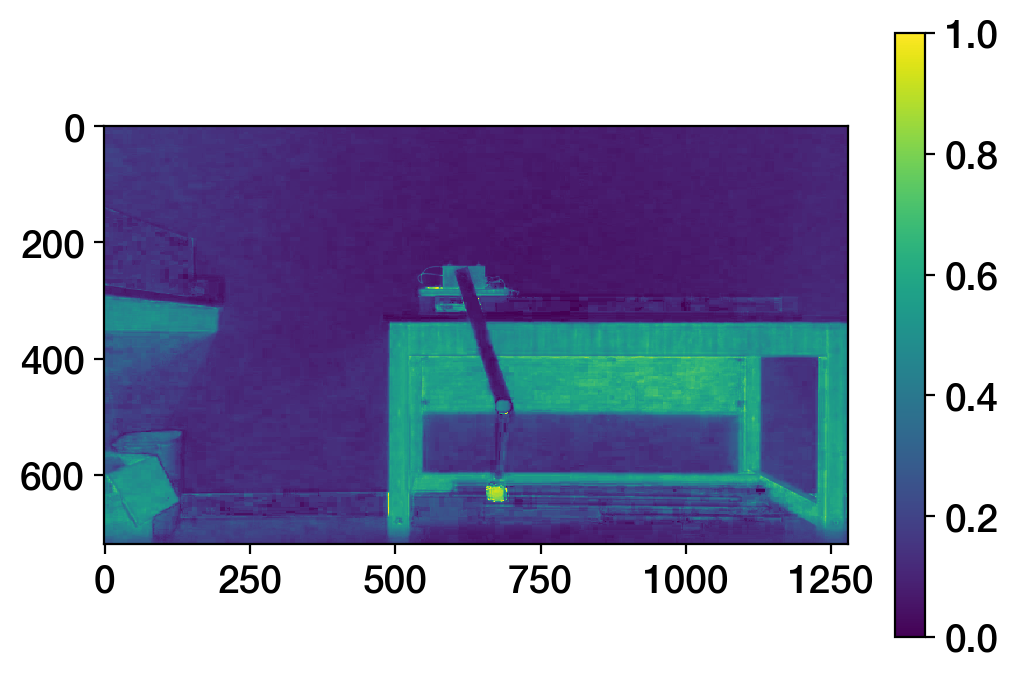

In [16]:
pl.imshow(saturation)
pl.colorbar()

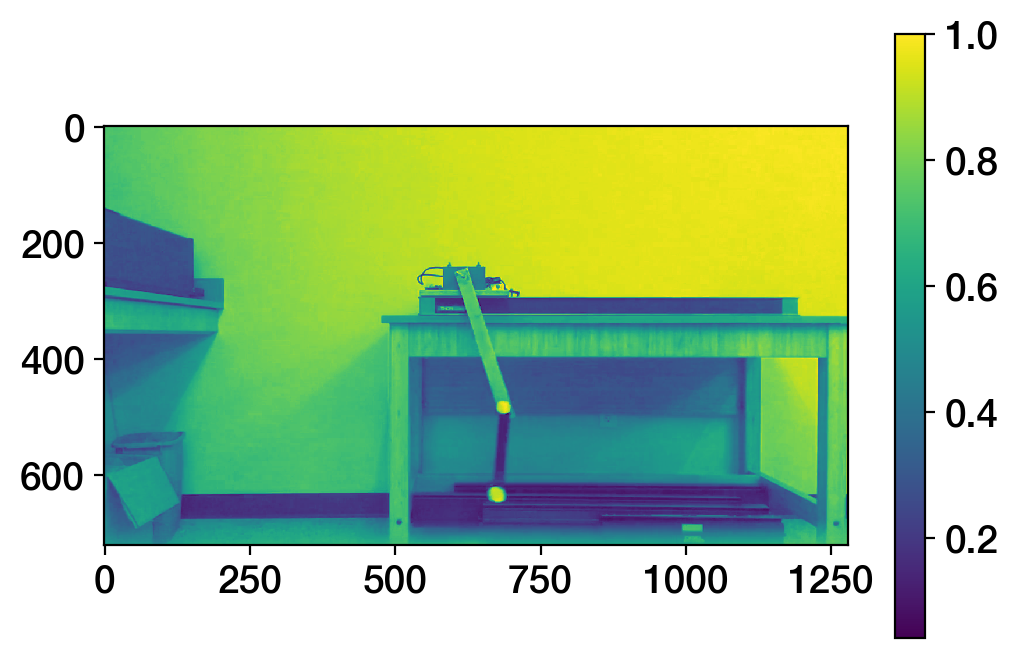

In [17]:
pl.imshow(luminance)
pl.colorbar()

### Distinguish markers

"Knee" is pale blue

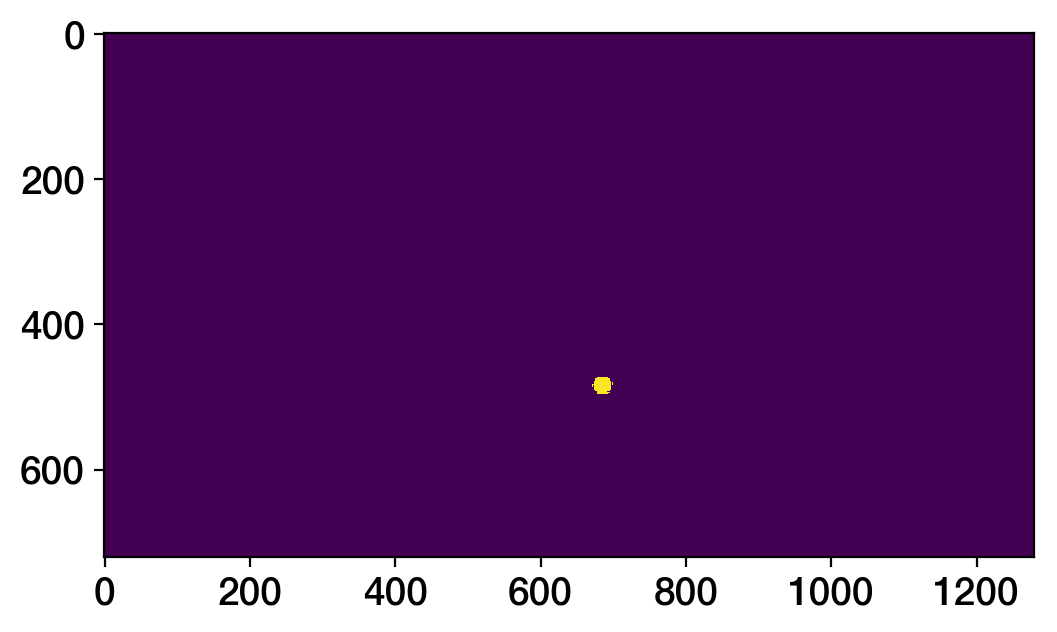

In [18]:
im_knee = (saturation >= 0.2) & (hue > 0.4) & (hue < 0.6)
pl.imshow(im_knee)

"Foot" is bright yellow

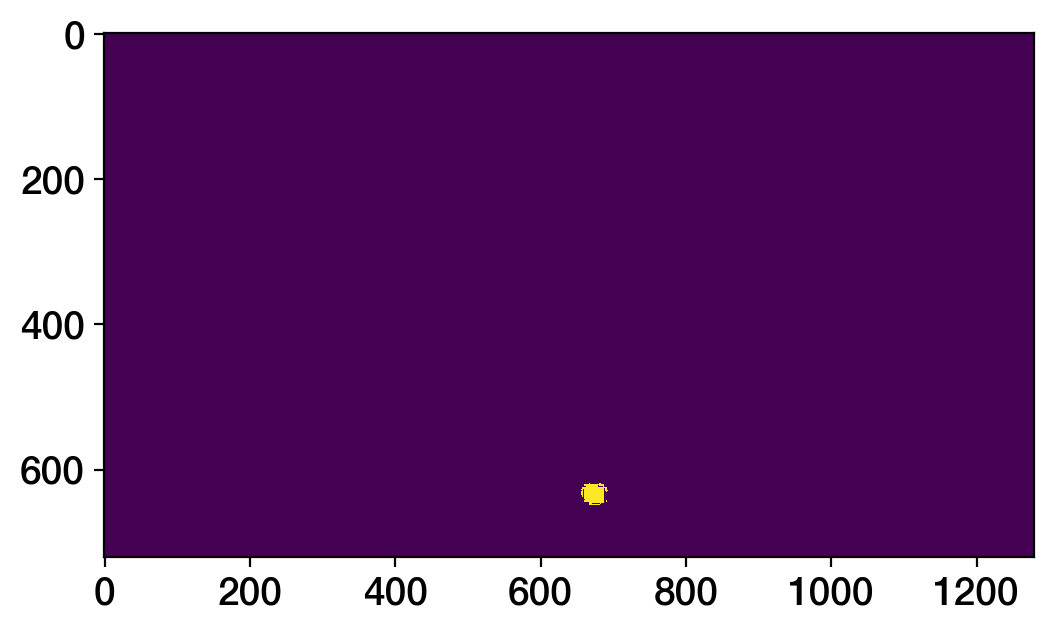

In [19]:
im_foot = (saturation >= 0.6) & (hue > 0.1) & (hue < 0.3)
pl.imshow(im_foot)

## Find centroids of markers

Find the centroid of any binary region using `skimage`

In [26]:
im_label = skimage.measure.label(im_foot)
regions = skimage.measure.regionprops(im_label)

In [27]:
len(regions)

3

There should be only one!

Let's take a closer look…

(600, 700)

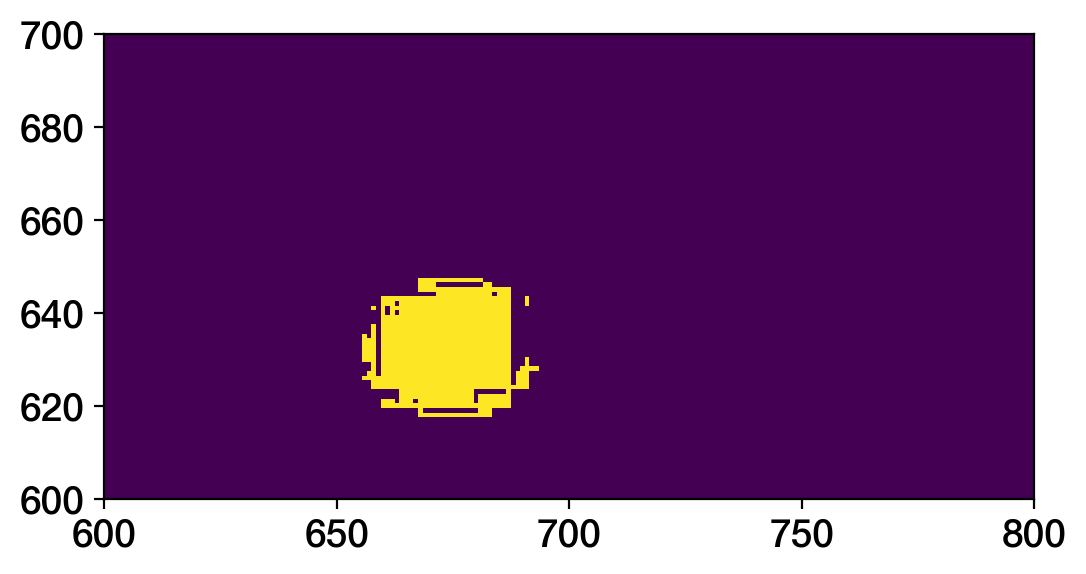

In [21]:
pl.imshow(im_foot)
pl.xlim(600, 800)
pl.ylim(600, 700)

### Remove spurious regions

In [28]:
# Everything with an area less than 50 pixels
im_foot = skimage.morphology.remove_small_objects(im_foot, 50)

(600, 700)

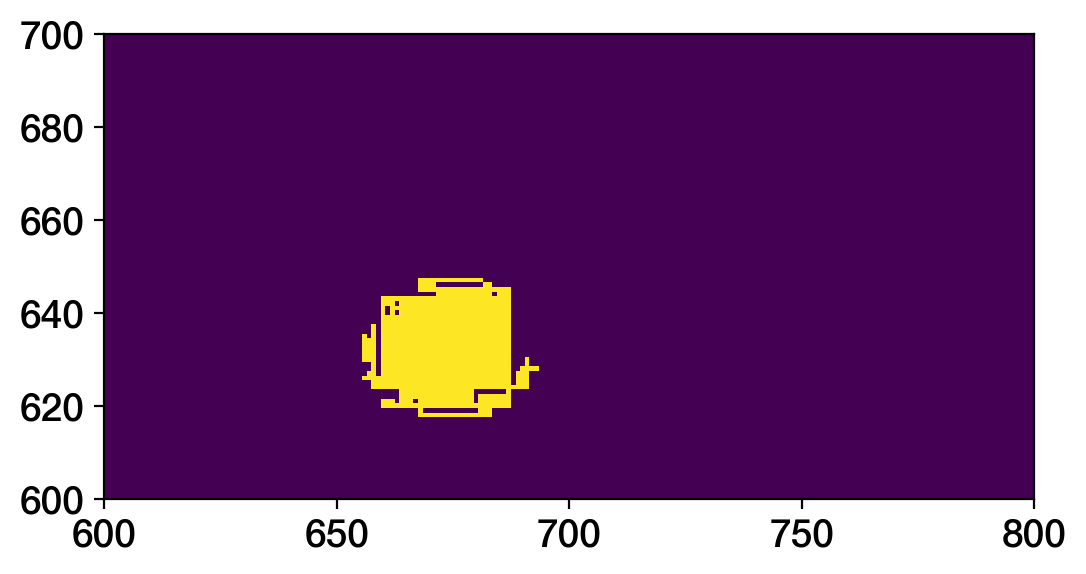

In [32]:
pl.imshow(im_foot)
pl.xlim(600, 800)
pl.ylim(600, 700)

In [33]:
im_label = skimage.measure.label(im_foot)
regions = skimage.measure.regionprops(im_label)
len(regions)

1

In [34]:
regions[0].centroid

(632.1369509043927, 673.673126614987)

## Define function and extract coordinates

Bring together everything we've done

In [39]:
def find_spot(im_binary, min_area=50):
    """Return x, y centroid of a large blob in a binary image."""
    im_cleaned = skimage.morphology.remove_small_objects(im_binary, min_area)
    im_label = skimage.measure.label(im_cleaned)
    regions = skimage.measure.regionprops(im_label)
    if len(regions) != 1:
        raise ValueError('Image must have exactly one large region.')
    y, x = regions[0].centroid
    return x, y

In [41]:
pos_knee_list, pos_foot_list = [], []

for im in frames:
    hsv = skimage.color.rgb2hsv(im)
    hue, saturation, luminance = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    im_knee = (saturation >= 0.2) & (hue > 0.4) & (hue < 0.6)
    im_foot = (saturation >= 0.6) & (hue > 0.1) & (hue < 0.3)
    pos_knee_list.append(find_spot(im_knee))
    pos_foot_list.append(find_spot(im_foot))

In [42]:
for pos in pos_knee_list:
    print(pos)

(834.5211538461539, 347.80961538461537)
(849.4077868852459, 298.01229508196724)
(842.3064516129032, 327.9233870967742)
(799.4226804123712, 407.1567010309278)
(685.2436647173489, 483.35087719298247)


# Analyze previously-found coordinates

In another notebook, we analyze the full movie (~4500 frames) and save the results to disk.

Effective frame rate = 120 frames/s.

In [47]:
coords = pd.read_csv('dbl_pend_120fps_coords.csv')
coords.drop(columns=['Unnamed: 0'], inplace=True)
coords.head()

,xfoot,yfoot,xknee,yknee
0,891.814815,8.723457,823.686722,144.983402
1,894.436031,8.449086,822.179752,142.423554
2,895.895141,8.485934,821.504202,140.754202
3,897.445000,8.512500,821.114919,140.010081
4,900.036842,8.500000,820.781971,139.383648


The markers oscillate!

Text(0.5, 0, 'Frame')

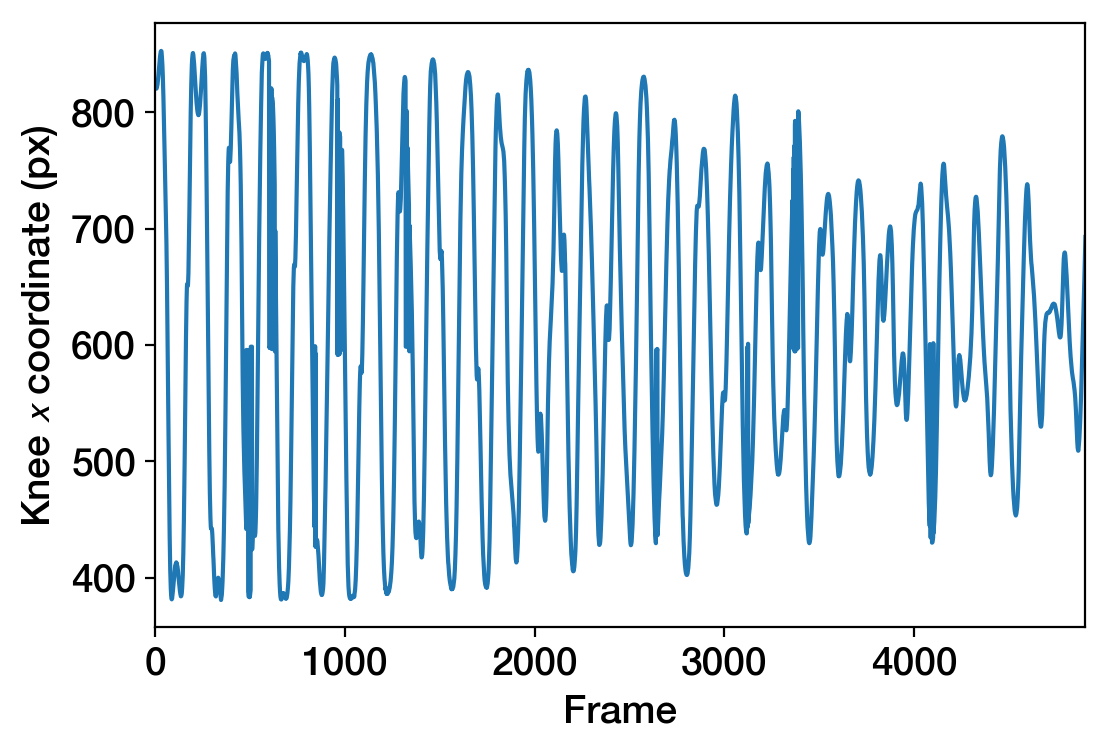

In [49]:
coords.xknee.plot()
pl.ylabel('Knee $x$ coordinate (px)')
pl.xlabel('Frame')

## Put into a "centered" reference frame

Text(0.5, 0, 'Frame')

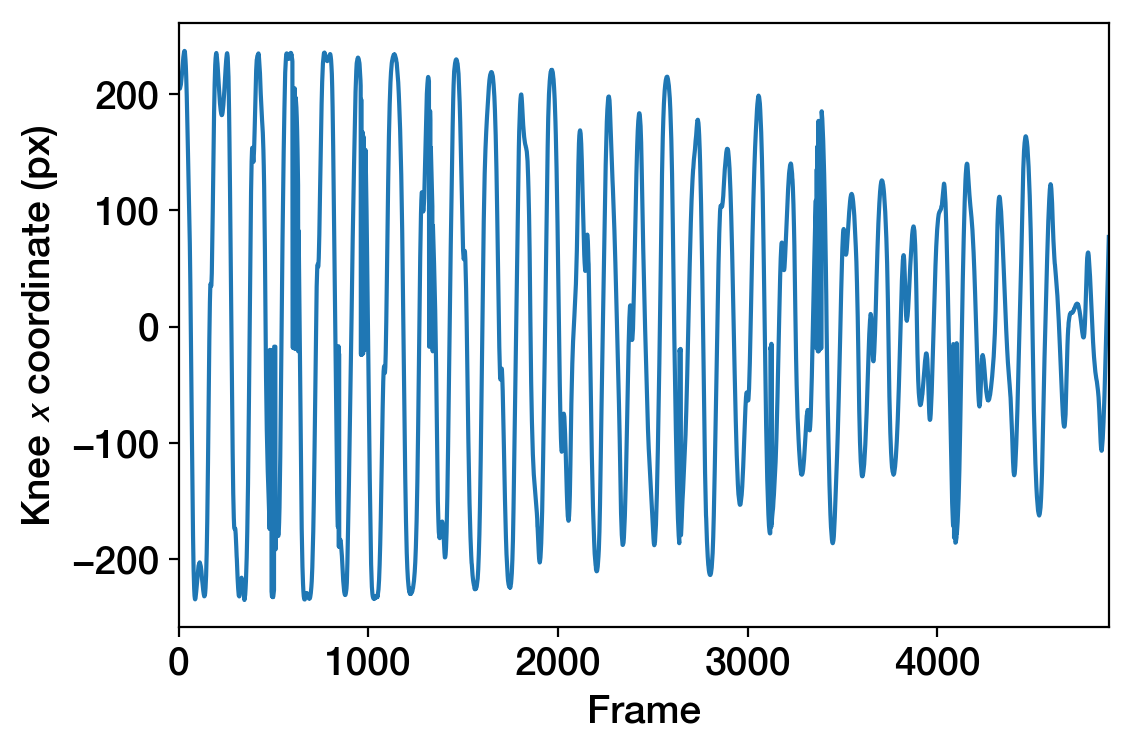

In [52]:
coords_centered = coords - coords.mean()
coords_centered.xknee.plot()
pl.ylabel('Knee $x$ coordinate (px)')
pl.xlabel('Frame')

## Trajectory

Text(0.5, 1.0, 'Pendulum foot trajectory')

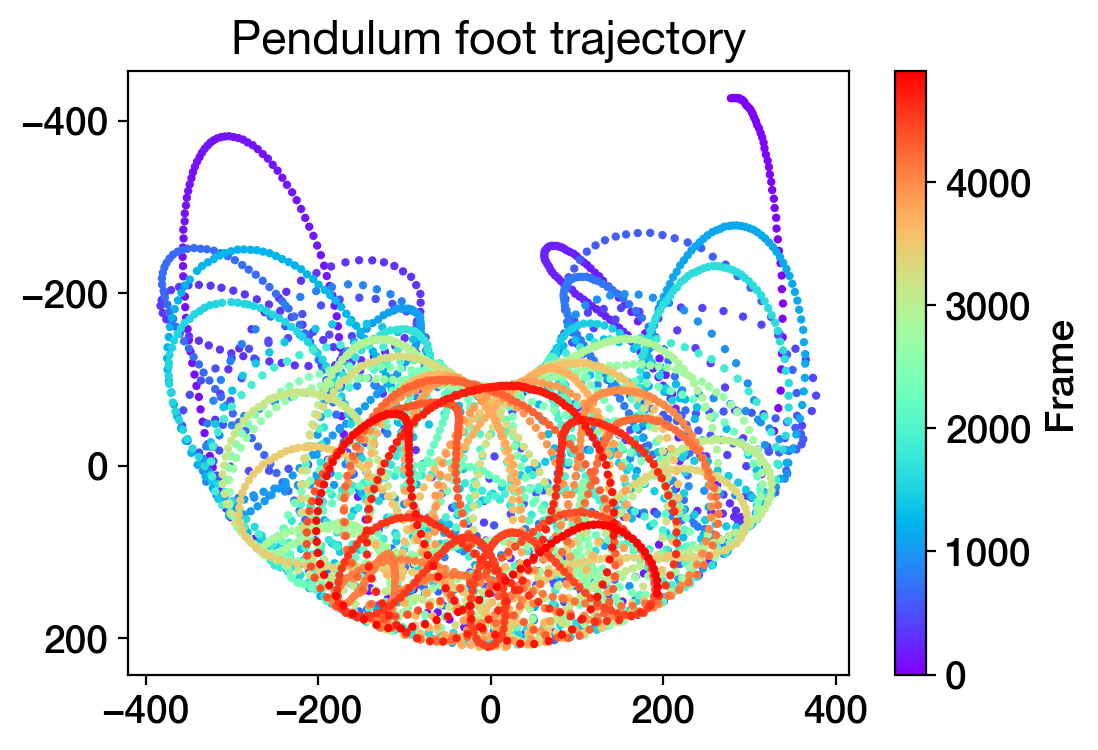

In [53]:
pl.scatter(coords_centered['xfoot'], coords_centered['yfoot'], c=range(len(coords_centered)), cmap=pl.cm.rainbow, s=4)
pl.axis('image')
pl.ylim(*pl.ylim()[::-1])
pl.colorbar(label='Frame')
pl.title('Pendulum foot trajectory')

## Phase portrait of the "knee"

Text(0.5, 0, '$x_\\mathrm{knee}$')

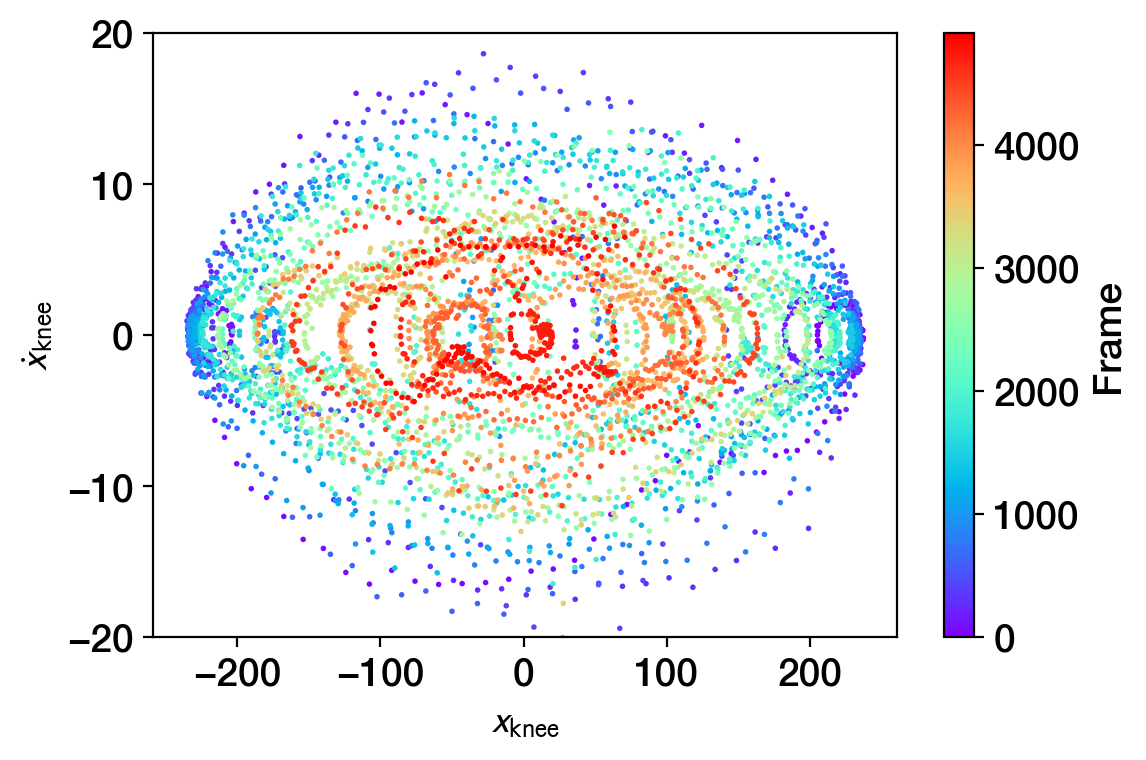

In [54]:
pl.scatter(coords_centered['xknee'].iloc[:-1], np.diff(coords_centered['xknee']),
          s=1, c=range(len(coords_centered) - 1), cmap=pl.cm.rainbow)
pl.ylim(-20, 20)
pl.colorbar(label='Frame')
pl.ylabel(r'$\dot x_\mathrm{knee}$')
pl.xlabel(r'$x_\mathrm{knee}$')

## "Foot" angle

Text(0, 0.5, 'Angle of lower segment (revolutions)')

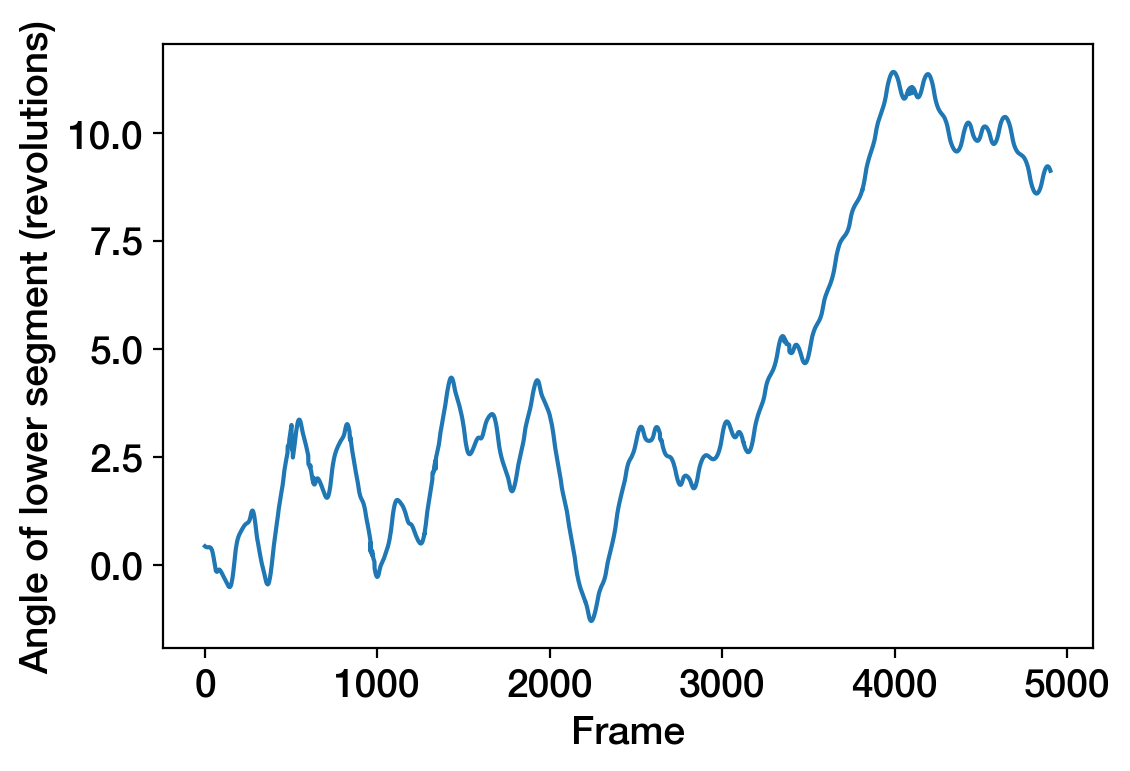

In [55]:
foot_angle = np.unwrap(np.arctan2(
    coords['xfoot'] - coords['xknee'], 
    coords['yfoot'] - coords['yknee'])) / 2 / np.pi
pl.plot(foot_angle)
pl.xlabel('Frame')
pl.ylabel('Angle of lower segment (revolutions)')

### Phase portrait of foot angle

Text(0, 0.5, 'Angular velocity (rev/frame)')

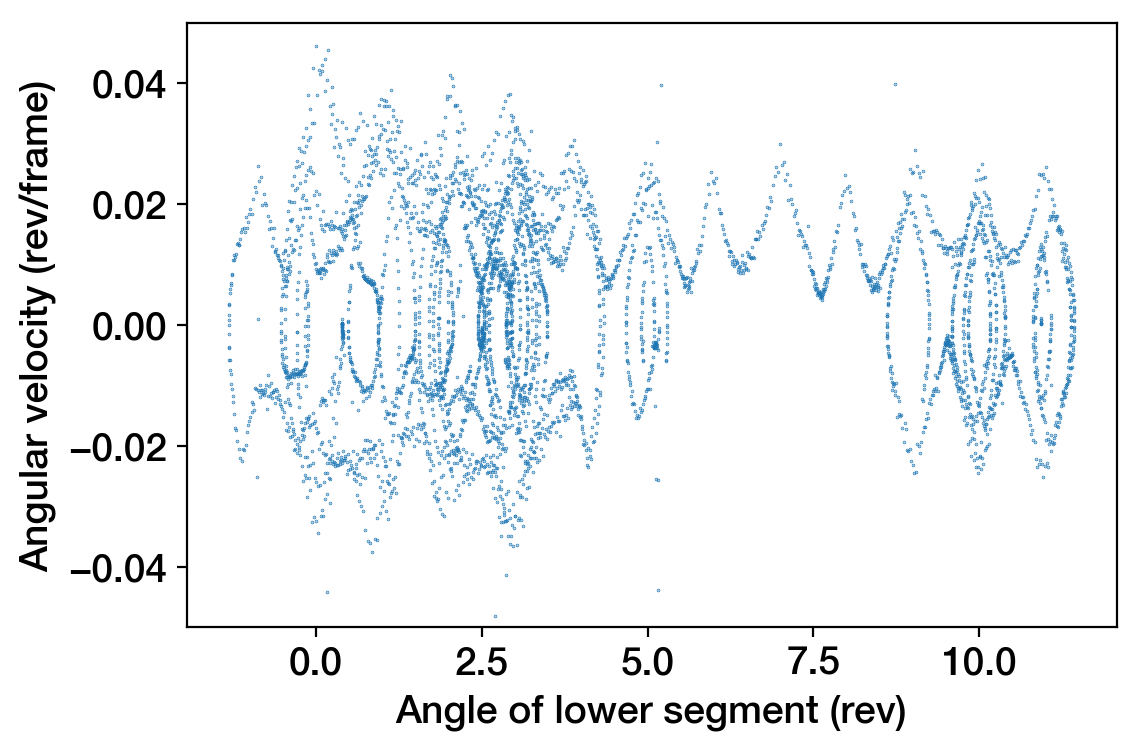

In [62]:
pl.plot(foot_angle[1:], np.diff(foot_angle), '.', ms=0.5)
#pl.xlim(50, 80)
pl.ylim(-0.05, 0.05)
pl.xlabel('Angle of lower segment (rev)')
pl.ylabel('Angular velocity (rev/frame)')

Text(0, 0.5, 'Angular velocity (rev/frame)')

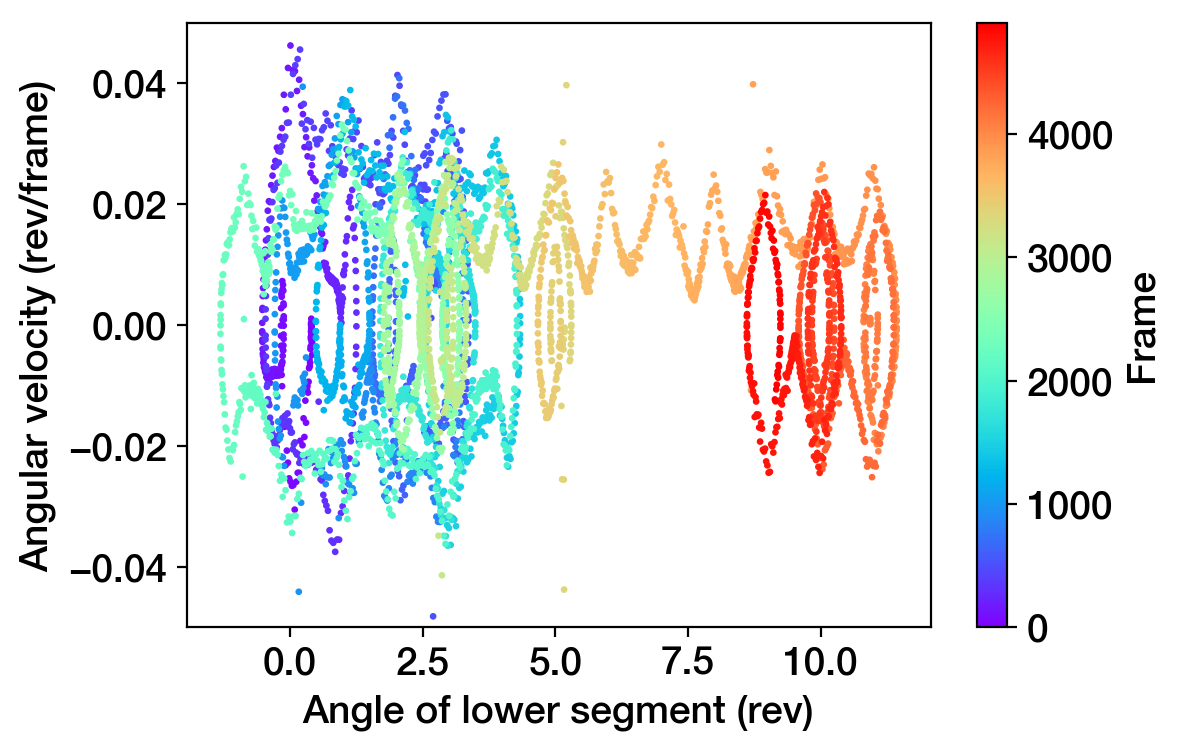

In [63]:
pl.scatter(foot_angle[1:], np.diff(foot_angle), 
           c=range(len(foot_angle) - 1), cmap=pl.cm.rainbow, s=2)
pl.ylim(-0.05, 0.05)
pl.colorbar(label='Frame')
pl.xlabel('Angle of lower segment (rev)')
pl.ylabel('Angular velocity (rev/frame)')

Text(0, 0.5, 'Angular velocity (rev/frame)')

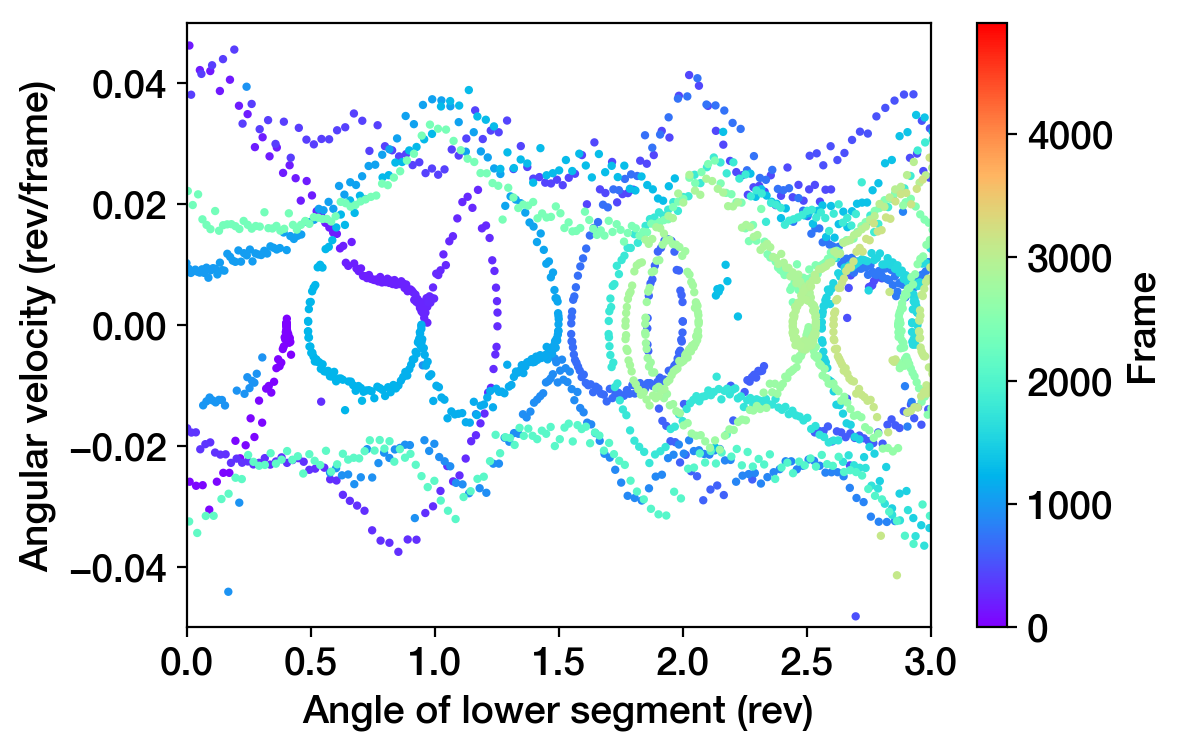

In [66]:
pl.scatter(foot_angle[1:], np.diff(foot_angle), 
           c=range(len(foot_angle) - 1), cmap=pl.cm.rainbow, s=4)
pl.xlim(0, 3)
pl.ylim(-0.05, 0.05)
pl.colorbar(label='Frame')
pl.xlabel('Angle of lower segment (rev)')
pl.ylabel('Angular velocity (rev/frame)')